In [300]:
import jax
jax.config.update('jax_enable_x64',True)
import jax.numpy as jnp
import pandas as pd
from jax.random import PRNGKey as pkey
from jax.scipy.special import expit
from jaxopt import LBFGS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')

In [2]:
beta_true = 1.
num_covs = 1
num_subjects_per_group = 500
num_groups = 4
total_subjects = num_subjects_per_group*num_groups
num_exposures = num_groups -1 
intercept_val = 0.2
confounding_constant = 0.0
assignment = jnp.vstack([jnp.arange(num_groups)]*num_subjects_per_group).T.flatten().reshape(-1,1)
covs = jnp.hstack([jax.random.normal(pkey(12),(total_subjects,num_covs))]) + confounding_constant*assignment
beta_covs = jax.random.normal(pkey(13),(num_covs,))
full_beta = jnp.hstack([beta_true,intercept_val,beta_covs])


#This is just for simulating
X_sim = jnp.hstack([assignment,jnp.ones((total_subjects,1)),covs])
Y_obs = jax.random.binomial(pkey(1),1,expit(X_sim@full_beta))

dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

model = sm.Logit(Y_obs, df_reg)
results = model.fit()
results.summary()

L = results.params[-num_exposures:].values
V = jnp.diag(results.cov_params().values[-num_exposures:,-num_exposures:])

Optimization terminated successfully.
         Current function value: 0.427639
         Iterations 7


In [307]:
beta_true = 0.2
gamma_true = 0.2
num_studies = 40
num_covs = 1
num_subjects_per_group = 200
num_groups = 4
total_subjects = num_subjects_per_group*num_groups
num_exposures = num_groups -1 
intercept_val = -1.
confounding_constant = 0.25

def simulate_study(key):
    keys = jax.random.split(key,10)

    assignment = jnp.vstack([jnp.arange(num_groups)]*num_subjects_per_group).T.flatten().reshape(-1,1)
    covs = jnp.hstack([jax.random.normal(keys[0],(total_subjects,num_covs))]) + confounding_constant*assignment
    beta_covs = jax.random.normal(keys[2],(num_covs,))

    beta_perturb = jnp.sqrt(gamma_true)*jax.random.normal(keys[8])

    beta_study = beta_true+beta_perturb
    full_beta = jnp.hstack([beta_study,intercept_val,beta_covs])

    #This is just for simulating
    X_sim = jnp.hstack([assignment,jnp.ones((total_subjects,1)),covs])
    Y_obs = jax.random.binomial(keys[5],1,expit(X_sim@full_beta))

    dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
    X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

    df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

    dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
    X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

    df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

    model = sm.Logit(Y_obs, df_reg)
    results = model.fit(disp = 0)
    results.summary()

    summary_df = pd.DataFrame({
        'assign':assignment[:,0],
        'is_case':Y_obs
    })
    total_non_cases = len(summary_df[summary_df['is_case']==0])
    reference_non_cases = len(summary_df[(summary_df['assign']==0)&(summary_df['is_case']==0)])
    p = reference_non_cases/total_non_cases
    total_cases = summary_df['is_case'].sum()
    z = total_non_cases/total_cases

    L = results.params[-num_exposures:].values
    V = jnp.diag(results.cov_params().values[-num_exposures:,-num_exposures:])
    return L,V,results,p,z

In [308]:
seed = 4
simulation_results = [
    simulate_study(pkey(10*i+seed)) for i in range(num_studies)
]

L_vals = [res[0] for res in simulation_results]
V_vals = [res[1] for res in simulation_results]
reg_vals = [res[2] for res in simulation_results]
p_vals = [res[3] for res in simulation_results]
z_vals = [res[4] for res in simulation_results]

cov_mats = [result.cov_params().values[-num_exposures:,-num_exposures:] for result in reg_vals]
z = jnp.arange(1.,1+num_exposures)
x = jnp.arange(1.,1+num_exposures)
fake_cov_mats = [jnp.diag(jnp.diag(C)) for C in cov_mats]

Zmat = jnp.outer(z,z)

logdet = jax.jit(lambda x:jnp.linalg.slogdet(x)[1])

def margin_like(gamma,covariance_matrices):
    vmats = jnp.array([Zmat*gamma + C for C in covariance_matrices])
    LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
    beta = (
        (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@x for V in vmats]))) * 
        (jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@L for V,L in zip(vmats,L_vals)])))
    )
    res_term = jnp.sum(jnp.array([(x*beta - L).T@jnp.linalg.inv(V)@(x*beta-L) for V,L in zip(vmats,L_vals)]))
    return LNV+res_term

gamma_grid = jnp.logspace(-4,2.,200)
nll_corr = jax.vmap(margin_like,in_axes = [0,None])(gamma_grid,cov_mats)
nll_diag = jax.vmap(margin_like,in_axes = [0,None])(gamma_grid,fake_cov_mats)

Diagonal Variance  0.18041864093920726
Correlated Variance  0.16831803533309567
True Gamma  0.2


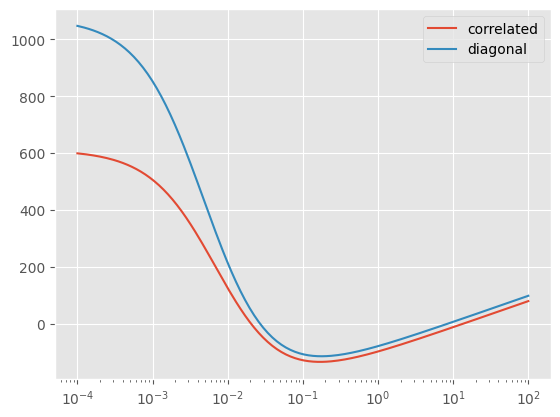

In [309]:
plt.plot(gamma_grid,nll_corr,label = 'correlated')
plt.plot(gamma_grid,nll_diag,label = 'diagonal')
plt.legend()
plt.xscale('log')
print("Diagonal Variance ",gamma_grid[jnp.argmin(nll_diag)])
print("Correlated Variance ",gamma_grid[jnp.argmin(nll_corr)])
print("True Gamma ", gamma_true)

In [310]:
seed = 4
simulation_results = [
    simulate_study(pkey(10*i+seed)) for i in range(num_studies)
]

def estimate_gamma(simulation_results):
    L_vals = [res[0] for res in simulation_results]
    V_vals = [res[1] for res in simulation_results]
    reg_vals = [res[2] for res in simulation_results]
    p_vals = [res[3] for res in simulation_results]
    z_vals = [res[4] for res in simulation_results]

    cov_mats = [result.cov_params().values[-num_exposures:,-num_exposures:] for result in reg_vals]
    z = jnp.arange(1.,1+num_exposures)
    x = jnp.arange(1.,1+num_exposures)
    fake_cov_mats = [jnp.diag(jnp.diag(C)) for C in cov_mats]

    Zmat = jnp.outer(z,z)

    logdet = jax.jit(lambda x:jnp.linalg.slogdet(x)[1])

    def margin_like(gamma,covariance_matrices):
        vmats = jnp.array([Zmat*gamma + C for C in covariance_matrices])
        LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
        beta = (
            (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@x for V in vmats]))) * 
            (jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@L for V,L in zip(vmats,L_vals)])))
        )
        res_term = jnp.sum(jnp.array([(x*beta - L).T@jnp.linalg.inv(V)@(x*beta-L) for V,L in zip(vmats,L_vals)]))
        return LNV+res_term

    gamma_grid = jnp.logspace(-4,2.,200)
    nll_corr = jax.vmap(margin_like,in_axes = [0,None])(gamma_grid,cov_mats)
    nll_diag = jax.vmap(margin_like,in_axes = [0,None])(gamma_grid,fake_cov_mats)
    return gamma_grid[jnp.argmin(nll_corr)],gamma_grid[jnp.argmin(nll_diag)]

In [311]:
corr_estimates = []
diag_estimates = []
seed = 13
keys_outer = jax.random.split(pkey(seed),100)

for i in tqdm(range(100)):
    keys = jax.random.split(keys_outer[i],num_studies)
    simulation_results = [
        simulate_study(keys[i]) for i in range(num_studies)
    ]
    corr,diag = estimate_gamma(simulation_results)
    corr_estimates+=[corr]
    diag_estimates+=[diag]
corr_estimates=jnp.array(corr_estimates)
diag_estimates = jnp.array(diag_estimates)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Corr Mean 0.183, Diag Mean 0.189')

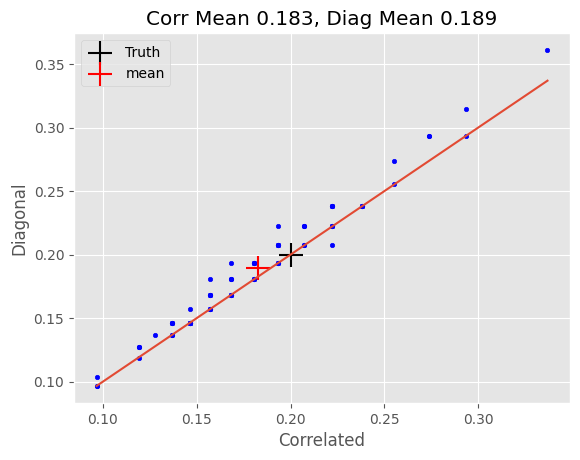

In [312]:
plt.scatter(corr_estimates,diag_estimates,s = 10,c = 'blue')
plt.scatter(gamma_true,gamma_true,
            s = 300,c = 'black',marker = '+',
            label = "Truth"
            )
plt.xlabel("Correlated")
plt.ylabel("Diagonal")

plt.scatter(jnp.mean(corr_estimates),jnp.mean(diag_estimates),
            marker = '+',label = 'mean',c = 'red',
            s = 300
            )
plt.legend()
plt.plot([jnp.min(corr_estimates),jnp.max(corr_estimates)],[jnp.min(corr_estimates),jnp.max(corr_estimates)])
plt.title(f"Corr Mean {jnp.mean(corr_estimates):.3f}, Diag Mean {jnp.mean(diag_estimates):.3f}")

In [299]:
print(jnp.mean(corr_estimates))
print(jnp.std(corr_estimates))

print(jnp.mean(diag_estimates))
print(jnp.std(diag_estimates))

0.18476489456312156
0.059109808723711
0.19177098481666652
0.060760791338903164


In [313]:
print(jnp.mean(corr_estimates))
print(jnp.std(corr_estimates))

print(jnp.mean(diag_estimates))
print(jnp.std(diag_estimates))

0.18265618090786345
0.044379943709496175
0.18910985009612746
0.04669714784483849


In [315]:
print(jnp.std(corr_estimates)/jnp.sqrt(100))


0.004437994370949617


Array(0.06076079, dtype=float64)

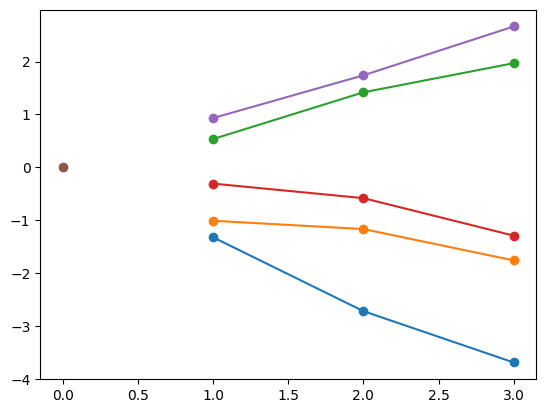

In [140]:
for L in L_vals:
    plt.plot(x,L)
    plt.scatter(x,L)

plt.scatter(0,0)

In [141]:
gamma = 0.5
vmats = jnp.array([Zmat*gamma + C for C in cov_mats])
LNV = jnp.sum(jnp.array([jnp.linalg.slogdet(V)[1] for V in vmats]))
beta = (
    (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@x for V in vmats]))) * 
    (jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@L for V,L in zip(vmats,L_vals)])))
)

In [154]:
V = vmats[0]
(1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@x for V in vmats])))

Array(0.1069542, dtype=float64)

In [155]:
(jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@L for V,L in zip(vmats,L_vals)])))

Array(-1.08302083, dtype=float64)

In [156]:
x.T@jnp.linalg.inv(V)@L

Array(1.57947356, dtype=float64)

In [167]:
num_groups = 5
num_per_group  = 10

group_var = 1.
individual_var = 1.

mu = 1.

C_true = (
    group_var * jnp.kron(jnp.eye(num_groups),jnp.ones((num_per_group,num_per_group))) + 
    individual_var * jnp.eye(num_groups*num_per_group)
)

sample = jax.random.multivariate_normal(pkey(12),mean = mu*jnp.ones(len(C_true)),cov = C_true)

In [168]:
x = 

def nll_simple(gamma):
    

Array([-0.34656707,  0.88850025,  0.09376597, -0.05788787,  0.17270331,
       -0.61769632, -0.32347781,  0.23224011,  0.21335326,  0.07999383,
       -0.75980902, -1.05237699, -0.06387265, -0.09437524, -0.09245224,
       -0.33070329, -0.69096165, -0.27640631, -1.21034155, -1.07644095,
        0.14669255,  0.46413859,  1.57596807,  0.81930226,  1.47045005,
       -0.24009601,  2.23246253,  1.83336523,  0.38642024,  1.01916897,
        2.1698581 ,  2.67582076,  1.84264939,  2.57240867,  2.11408774,
        2.27005482,  1.27632984,  2.45108434,  2.61155609,  2.0380058 ,
        1.02736277, -0.44397484,  0.52785645,  0.16629845, -0.97380143,
        0.33585375, -0.22249719, -0.50065981,  0.40957457,  0.39557681],      dtype=float64)